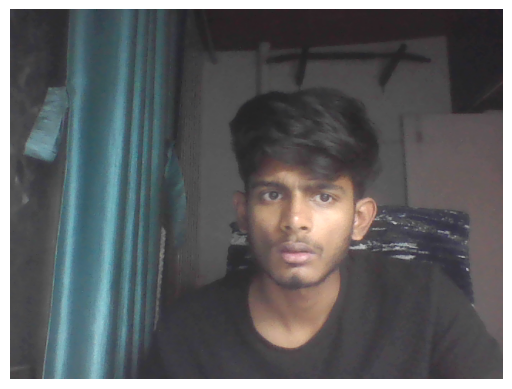

Stopped by user.


In [1]:
import cv2
import pytesseract
import re
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import clear_output

# Configure Tesseract-OCR
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to extract dates and classify them
def extract_dates_with_keywords(text):
    # Keywords for identifying the context of dates
    expiry_keywords = ["expiry", "best before", "use by", "exp"]
    manufacturing_keywords = ["manufacturing", "mfg", "packed on"]

    # Define patterns for date detection
    date_patterns = [
        r"\b(\d{2}[\/\-\.]\d{4})\b",          # MM/YYYY or DD/YYYY
        r"\b(\d{4}[\/\-\.]\d{2})\b",          # YYYY/MM or YYYY/DD
        r"\b(\d{1,2}[\/\-\.]\d{1,2}[\/\-\.]\d{4})\b",  # DD/MM/YYYY or MM/DD/YYYY
        r"\b(\d{4}[\/\-\.]\d{1,2}[\/\-\.]\d{1,2})\b",  # YYYY/MM/DD
        r"\b([A-Za-z]{3,9}\s\d{4})\b",        # Month YYYY
    ]
    detected_dates = []
    for pattern in date_patterns:
        matches = re.findall(pattern, text)
        detected_dates.extend(matches)

    # Classify dates based on nearby keywords
    date_info = {}
    for date in detected_dates:
        # Search for keywords near the date
        date_index = text.find(date)
        surrounding_text = text[max(0, date_index - 30):date_index + 30].lower()

        if any(keyword in surrounding_text for keyword in expiry_keywords):
            date_info[date] = "EXP"
        elif any(keyword in surrounding_text for keyword in manufacturing_keywords):
            date_info[date] = "MFG"
        else:
            date_info[date] = "Unknown"

    return date_info

# Function to determine expiry status and time left
def check_expiry(dates):
    today = datetime.today()
    expiry_status = []
    for date, label in dates.items():
        try:
            # Try parsing the date in different formats
            date_obj = None
            if len(date) == 7:  # MM/YYYY
                date_obj = datetime.strptime(date, "%m/%Y")
            elif len(date) == 10:  # DD/MM/YYYY or MM/DD/YYYY
                date_obj = datetime.strptime(date, "%d/%m/%Y")
            
            if date_obj:
                if label == "EXP":
                    if date_obj < today:
                        expiry_status.append((date, "Expired"))
                    else:
                        delta = date_obj - today
                        months_left = delta.days // 30
                        years_left = months_left // 12
                        expiry_status.append((date, f"{years_left} years, {months_left % 12} months left"))
                elif label == "MFG":
                    expiry_status.append((date, "Manufacturing Date"))
                else:
                    expiry_status.append((date, "Unknown Label"))
        except ValueError:
            expiry_status.append((date, "Invalid format"))
    return expiry_status

# Preprocessing Function
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray)  # Apply CLAHE
    _, binary_image = cv2.threshold(enhanced_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Thresholding
    return binary_image

# Webcam Capture
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

plt.ion()  # Enable real-time interactive mode

try:
    while True:
        # Capture image from webcam
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        # Preprocessing for OCR
        processed_frame = preprocess_image(frame)

        # OCR extraction
        custom_config = '--psm 6'  # Treat image as a single block of text
        text = pytesseract.image_to_string(processed_frame, config=custom_config)
        date_info = extract_dates_with_keywords(text)
        expiry_info = check_expiry(date_info)

        # Display results in text form
        print("\nRaw OCR Text:", text)
        print("Detected Dates with Status:")
        for date, status in expiry_info:
            print(f"Date: {date}, Status: {status}")

        # Annotate the frame
        annotated_frame = frame.copy()
        y_offset = 30
        for date, status in expiry_info:
            cv2.putText(annotated_frame, f"Date: {date}, Status: {status}", (10, y_offset),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            y_offset += 30

        # Display the annotated frame using Matplotlib
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

except KeyboardInterrupt:
    print("Stopped by user.")
finally:
    cap.release()
    plt.ioff()

